In [ ]:
!pip install -qU bertopic pandas nltk scikit-learn matplotlib xlwt 

In [1]:
# ============================================
# 0. CONFIGURATION & PARAMETERS
# ============================================

name = "holifood"     # define project name

# --- Data paths ---
DATA_PATH = '/home/jupyter/WSM/data/holifood_input.csv'

# --- Column names in the CSV ---
TEXT_COLUMN = 'Abstract'
DATE_COLUMN = 'Date'

# --- Embedding model ---
SENTENCE_MODEL_NAME = 'all-MiniLM-L12-v2'

# --- UMAP parameters ---
UMAP_N_NEIGHBORS = 15
UMAP_N_COMPONENTS = 5
UMAP_MIN_DIST = 0.0
UMAP_METRIC = 'cosine'

# --- HDBSCAN parameters ---
HDBSCAN_MIN_CLUSTER_SIZE = 5
HDBSCAN_MIN_SAMPLES = 5
HDBSCAN_METRIC = 'euclidean'
HDBSCAN_CLUSTER_SELECTION_METHOD = 'leaf'
HDBSCAN_CLUSTER_SELECTION_EPSILON = 0.1

In [2]:
# ============================================
# 1. IMPORTS
# ============================================

import re
import numpy as np
import pandas as pd

from sentence_transformers import SentenceTransformer
from umap import UMAP
import hdbscan
from bertopic import BERTopic

import plotly.express as px


In [3]:
# ============================================
# 2. LOAD & PREPROCESS DATA
# ============================================

# Load CSV
docs = pd.read_csv(DATA_PATH)

# Basic cleaning: require both text and date
docs = docs.dropna(subset=[TEXT_COLUMN, DATE_COLUMN])
docs = docs.reset_index(drop=True)
print(f"Loaded {len(docs)} rows after initial dropna().")

# Ensure text column is string
docs[TEXT_COLUMN] = docs[TEXT_COLUMN].astype(str)

# ---- Count before date parsing ----
count_before_date_parse = len(docs)

# Parse dates
docs[DATE_COLUMN] = pd.to_datetime(docs[DATE_COLUMN], errors='coerce')

# Drop rows with unparseable dates
docs = docs.dropna(subset=[DATE_COLUMN]).reset_index(drop=True)

# ---- Count after date parsing ----
count_after_date_parse = len(docs)

print(f"Rows before parsing dates:  {count_before_date_parse}")
print(f"Rows after date parsing:   {count_after_date_parse}")
print(f"Dropped due to bad dates:  {count_before_date_parse - count_after_date_parse}")

# Extract Year
docs["Year"] = docs[DATE_COLUMN].dt.year

# Publications per year
pubs_per_year = docs["Year"].value_counts().sort_index()
print("Publications per year:")
print(pubs_per_year)


Loaded 8202 rows after initial dropna().
Rows before parsing dates:  8202
Rows after date parsing:   8202
Dropped due to bad dates:  0
Publications per year:
Year
2018       3
2019     126
2020    1478
2021    1573
2022    1663
2023    1668
2024    1683
2025       8
Name: count, dtype: int64


In [4]:
# Count before filtering
count_before_year_filter = len(docs)

# Keep only publications between 2004 and 2007 (inclusive)
docs = docs[(docs["Year"] >= 2020) & (docs["Year"] <= 2024)].reset_index(drop=True)

# Count after filtering
count_after_year_filter = len(docs)

print(f"Rows before year filtering: {count_before_year_filter}")
print(f"Rows after year filtering:  {count_after_year_filter}")
print(f"Rows dropped:               {count_before_year_filter - count_after_year_filter}")

Rows before year filtering: 8202
Rows after year filtering:  8065
Rows dropped:               137


In [5]:
# Prepare the abstracts as a list for BERTopic
text = docs[TEXT_COLUMN].astype(str).tolist()
len(text)

8065

In [6]:
# ============================================
# 3. EMBEDDINGS & TOPIC MODELING
# ============================================

# 3.1 Sentence embeddings
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

sentence_model = SentenceTransformer(SENTENCE_MODEL_NAME, device=device)
embeddings = sentence_model.encode(
    text,
    show_progress_bar=True,
    normalize_embeddings=True,
)

# 3.2 UMAP: local structure for micro-topics
umap_model = UMAP(
    n_neighbors=UMAP_N_NEIGHBORS,
    n_components=UMAP_N_COMPONENTS,
    min_dist=UMAP_MIN_DIST,
    metric=UMAP_METRIC,
    random_state=42,
)

# 3.3 HDBSCAN: density-based clustering for many small topics
hdbscan_model = hdbscan.HDBSCAN(
    min_cluster_size=HDBSCAN_MIN_CLUSTER_SIZE,
    min_samples=HDBSCAN_MIN_SAMPLES,
    metric=HDBSCAN_METRIC,
    cluster_selection_method=HDBSCAN_CLUSTER_SELECTION_METHOD,
    cluster_selection_epsilon=HDBSCAN_CLUSTER_SELECTION_EPSILON,
    prediction_data=True,
)

# 3.4 BERTopic with custom UMAP + HDBSCAN
topic_model = BERTopic(
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    calculate_probabilities=False,
    verbose=False,
)

topics = topic_model.fit_transform(text, embeddings)

topic_info = topic_model.get_topic_info()
print(f"Number of topics (including outlier -1): {len(topic_info)}")
topic_info.head()


Using device: cuda


Batches:   0%|          | 0/253 [00:00<?, ?it/s]

Number of topics (including outlier -1): 402


,Topic,Count,Name,Representation,Representative_Docs
0,-1,976,-1_the_of_in_and,"[the, of, in, and, to, with, was, on, for, as]",[Poultry is thriving across the globe. Chicken...
1,0,141,0_icampylobacteri_campylobacter_jejunii_ic,"[icampylobacteri, campylobacter, jejunii, ic, ...",[Campylobacter is one of the most commonly rep...
2,1,87,1_salmonella_isalmonellai_isolates_resistance,"[salmonella, isalmonellai, isolates, resistanc...","[Salmonella, one of the most important foodbor..."
3,2,85,2_residues_method_antibiotic_veterinary,"[residues, method, antibiotic, veterinary, dru...",[The misuse of antibiotics in poultry farming ...
4,3,79,3_h9n2_viruses_virus_influenza,"[h9n2, viruses, virus, influenza, ha, aiv, avi...",[China is one of the highest producers of poul...


In [7]:
# ============================================
# 4. SAVE TOPIC MODEL (OPTIONAL)
# ============================================

# save_path = f"data/{name}_topic_model"
# topic_model.save(save_path, save_embedding_model=True)
# print(f"Model saved to: {save_path}")


In [8]:
# ============================================
# 5. BUILD DOC_INFO WITH DATES
# ============================================

# Make a clean copy of docs and ensure alignment
docs_model = docs.reset_index(drop=True).copy()
assert len(text) == len(docs_model), "len(text) must match len(docs)."

# Get document-level topic assignments from BERTopic
doc_info = topic_model.get_document_info(text).copy()

# Create a stable doc_id BEFORE any filtering
doc_info["doc_id"] = np.arange(len(doc_info))
docs_model["doc_id"] = np.arange(len(docs_model))

# Merge Date from docs_model into doc_info
doc_info = doc_info.merge(
    docs_model[["doc_id", DATE_COLUMN]],
    on="doc_id",
    how="left"
).rename(columns={DATE_COLUMN: "Date"})

# Drop outlier topic -1 AFTER alignment
doc_info = doc_info[doc_info["Topic"] != -1].copy()

# Ensure datetime
doc_info["Date"] = pd.to_datetime(doc_info["Date"], errors="coerce")

# Drop rows with missing dates (optional)
doc_info = doc_info.dropna(subset=["Date"]).copy()

# Convenience ID column
doc_info["ID"] = doc_info["doc_id"]

print(f"Documents available (after droping outlier topic): {len(doc_info)}")
doc_info.head()


Documents available (after droping outlier topic): 7089


,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document,doc_id,Date,ID
0,"Globally, chicken is known to be a reservoir f...",11,11_coli_esblproducing_esbl_esblec,"[coli, esblproducing, esbl, esblec, extendedsp...",[Antimicrobial resistance in bacteria is the m...,coli - esblproducing - esbl - esblec - extende...,1.000000,False,0,2020-05-27,0
1,Childhood stunting and malnutrition condemn mi...,386,386_stunting_ethiopia_eed_icampylobacteri,"[stunting, ethiopia, eed, icampylobacteri, vio...",[Childhood stunting and malnutrition condemn m...,stunting - ethiopia - eed - icampylobacteri - ...,1.000000,True,1,2020-03-23,1
3,Persistent organic pollutants (POPs) such as d...,23,23_pcddfs_polychlorinated_dioxin_fat,"[pcddfs, polychlorinated, dioxin, fat, eggs, d...",[Dioxins might be introduced into the food cha...,pcddfs - polychlorinated - dioxin - fat - eggs...,0.398548,False,3,2020-09-18,3
4,Indiscriminate antimicrobial use (AMU) in anim...,140,140_amu_smallscale_mixedgrass_pastures,"[amu, smallscale, mixedgrass, pastures, adg, i...",[Small-scale farming of meat chicken flocks us...,amu - smallscale - mixedgrass - pastures - adg...,0.734007,False,4,2021-01-28,4
5,<i>Lactobacillus crispatus</i> is a common inh...,93,93_lc2029_slp2_caco2_ht29,"[lc2029, slp2, caco2, ht29, il, probiotic, agi...",[Lactic acid bacteria are generally regarded a...,lc2029 - slp2 - caco2 - ht29 - il - probiotic ...,1.000000,False,5,2020-01-24,5


In [9]:
# ============================================
# 6. TOPIC METADATA (Name & Representation)
# ============================================

# Ensure we have a Name column for each document's topic
if 'Name' not in doc_info.columns or doc_info['Name'].isna().all():
    labels = topic_model.generate_topic_labels()
    doc_info['Name'] = doc_info['Topic'].map(labels)

# Get topic_info and ensure Representation is present
try:
    topic_info = topic_model.get_topic_info()
    if 'Representation' not in topic_info.columns:
        topic_info['Representation'] = topic_info['Name']
except Exception:
    topic_info = pd.DataFrame({'Name': doc_info['Name'].unique()})
    topic_info['Count'] = (
        doc_info['Name']
        .value_counts()
        .reindex(topic_info['Name'])
        .fillna(0)
        .astype(int)
    )
    topic_info['Representation'] = topic_info['Name']

topic_info.head()


,Topic,Count,Name,Representation,Representative_Docs
0,-1,976,-1_the_of_in_and,"[the, of, in, and, to, with, was, on, for, as]",[Poultry is thriving across the globe. Chicken...
1,0,141,0_icampylobacteri_campylobacter_jejunii_ic,"[icampylobacteri, campylobacter, jejunii, ic, ...",[Campylobacter is one of the most commonly rep...
2,1,87,1_salmonella_isalmonellai_isolates_resistance,"[salmonella, isalmonellai, isolates, resistanc...","[Salmonella, one of the most important foodbor..."
3,2,85,2_residues_method_antibiotic_veterinary,"[residues, method, antibiotic, veterinary, dru...",[The misuse of antibiotics in poultry farming ...
4,3,79,3_h9n2_viruses_virus_influenza,"[h9n2, viruses, virus, influenza, ha, aiv, avi...",[China is one of the highest producers of poul...


In [10]:
# ============================================
# 7. TOPIC SHARE BY TIME BUCKET (Y/2Q/Q/M/W/D)
# ============================================

# Set this to force a specific time bucket.
# Allowed values:
#   'Y'  = yearly
#   '2Q' = half-yearly (2 quarters)
#   'Q'  = quarterly
#   'M'  = monthly
#   'W'  = weekly
#   'D'  = daily
#   'auto' = automatic choice (tries M, then W, then D; same as before)
TIME_BUCKET = 'auto'

# Order of candidates used when TIME_BUCKET = 'auto'
AUTO_FREQ_CANDIDATES = ['M', 'W', 'D']


def shares_by_freq(df: pd.DataFrame, freq: str) -> pd.DataFrame:
    """Group documents into time buckets and compute per-topic share within each bucket.

    freq:
        'Y'  = yearly
        '2Q' = half-yearly (2 quarters)
        'Q'  = quarterly
        'M'  = monthly
        'W'  = weekly
        'D'  = daily
    """
    tmp = df.copy()
    tmp['Bucket'] = tmp['Date'].dt.to_period(freq).dt.to_timestamp()

    counts = (
        pd.pivot_table(
            tmp,
            index='Bucket',
            columns='Name',   # <-- keep Name as in the original version
            values='ID',
            aggfunc='count',
            fill_value=0,
        )
        .sort_index()
    )

    if len(counts) == 0:
        return counts

    # Per-bucket topic shares (row-normalized)
    row_sums = counts.sum(axis=1).replace(0, 1)
    shares = counts.div(row_sums, axis=0)
    return shares


# Choose bucket either by forcing TIME_BUCKET or via automatic selection
shares, chosen = None, None

if TIME_BUCKET != 'auto':
    # Force a specific frequency (Y, 2Q, Q, M, W, or D)
    chosen = TIME_BUCKET
    shares = shares_by_freq(doc_info, chosen)
else:
    # Original behavior: try month, then week, then day
    for f in AUTO_FREQ_CANDIDATES:
        s = shares_by_freq(doc_info, f)
        if len(s) >= 2:
            shares, chosen = s, f
            break

print(f"Chosen time bucket: {chosen}")
if shares is not None:
    display(shares.head())


Chosen time bucket: M


Name,0_icampylobacteri_campylobacter_jejunii_ic,100_fortification_biofortified_vitamin_mills,101_frying_gcas_oil_cla,102_light_lighting_retina_glaucoma,103_patients_ckd_plantbased_pbmas,104_corticosterone_cort_chem_steroid,105_smothering_nest_feather_lgds,106_pneumoniae_pneumoniaei_ik_crkp,107_sarscov2_covid19_igy_coronavirus,108_iron_anemia_anaemia_amaranth,...,91_aiv_bangladesh_h5_lbms,92_lentil_lentils_nf_fe,93_lc2029_slp2_caco2_ht29,94_diclofenac_renal_uric_vultures,95_ibdv_bursal_vaccine_ibd,96_cdinduced_lut_hnk_liver,97_intake_cancer_colorectal_crc,98_hyperspectral_feature_accuracy_kernels,99_perfringensi_cperfringens_ic_clostridium,9_si_arsenic_plants_stress
Bucket,,,,,,,,,,,,,,,,,,,,,
2020-01-01,0.044444,0.000000,0.000000,0.0,0.0,0.022222,0.0,0.011111,0.022222,0.0,...,0.000000,0.0,0.022222,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2020-02-01,0.046512,0.000000,0.023256,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.023256,0.0,0.023256,0.0,0.023256,0.0,0.000000,0.000000,0.046512,0.000000
2020-03-01,0.020833,0.000000,0.010417,0.0,0.0,0.010417,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.020833,0.000000,0.000000
2020-04-01,0.010000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.020000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.020000
2020-05-01,0.069565,0.008696,0.000000,0.0,0.0,0.034783,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.017391,0.0,0.000000,0.0,0.017391,0.000000,0.017391,0.017391


In [11]:
# ============================================
# 8. Topic Emergence SCORE
# ============================================

# --- Time filtering & recency scoring ---
HALF_LIFE = 1.0                # in units of chosen bucket (M/W/D)

# --- magnitude weighting ---
magnitude_ALPHA = 1.5               # strength of magnitude contribution
magnitude_EPS = 1e-9                # to avoid division by zero in relative jumps
ALPHA = 1

import numpy as np
import pandas as pd

if shares is None:
    # Fallback: chronological 80/20 split of documents (no time buckets)
    df_sorted = doc_info.sort_values("Date").reset_index(drop=True)
    onehot = pd.crosstab(df_sorted.index, df_sorted["Name"])

    cut = max(1, min(len(df_sorted) - 1, int(len(df_sorted) * 0.8)))
    recent = onehot.iloc[cut:].sum()

    recent_total = recent.sum() or 1
    recency_score = (recent / recent_total).rename("recency_score")

    print("Used 80/20 chronological split as fallback (no time buckets).")

    # No buckets → no magnitude information available
    magnitude_strength = pd.Series(0.0, index=recency_score.index, name="magnitude_strength")

    # In fallback, just mirror recency_score as recency_magnitude_score
    recency_magnitude_score = recency_score.copy().rename("recency_magnitude_score")

else:
    # 8.1 Recency: exponential decay in time (HALF_LIFE in units of `chosen`)
    ages = np.arange(len(shares))[::-1]  # 0 = newest bucket
    weights = pd.Series(0.5 ** (ages / HALF_LIFE), index=shares.index)
    weights = weights / weights.sum()

    recency_score = (shares.T @ weights).rename("recency_score")

    # 8.2 magnitude: last bucket vs previous bucket
    last_share = shares.iloc[-1]
    if len(shares) > 1:
        prev_share = shares.iloc[-2]
    else:
        prev_share = 0.0 * last_share

    rel_magnitude = (last_share - prev_share) / (prev_share + magnitude_EPS)

    # Only care about positive jumps
    magnitude_strength = rel_magnitude.clip(lower=0.0).rename("magnitude_strength")

    # 8.3 Combine recency and magnitude into a single emergence score
    r = recency_score.clip(lower=0.0)
    j = magnitude_strength.clip(lower=0.0)

    if r.max() > 0:
        r_norm = r / r.max()
    else:
        r_norm = r

    if j.max() > 0:
        j_norm = j / j.max()
    else:
        j_norm = j

    # Weight between recency and magnitude; tune ALPHA if you like
    topic_emergence_score = (ALPHA * r_norm + (1 - ALPHA) * j_norm).rename("topic_emergence_score")

    print(
        f"Computed recency_score (half-life={HALF_LIFE}, freq='{chosen}'), "
        "magnitude_strength (last vs previous bucket), and topic_emergence_score."
    )

# Align indices (safety)
magnitude_strength = magnitude_strength.reindex(recency_score.index).fillna(0.0)
topic_emergence_score = topic_emergence_score.reindex(recency_score.index)

display(
    pd.DataFrame({
        "recency_score": recency_score,
        "magnitude_strength": magnitude_strength,
        "topic_emergence_score": topic_emergence_score,
    }).head()
)

Computed recency_score (half-life=1.0, freq='M'), magnitude_strength (last vs previous bucket), and topic_emergence_score.


,recency_score,magnitude_strength,topic_emergence_score
Name,,,
0_icampylobacteri_campylobacter_jejunii_ic,0.013715,0.0,0.462172
100_fortification_biofortified_vitamin_mills,0.002214,0.0,0.074604
101_frying_gcas_oil_cla,0.001009,0.0,0.034004
102_light_lighting_retina_glaucoma,0.002175,0.0,0.073277
103_patients_ckd_plantbased_pbmas,0.000139,0.0,0.004698


In [12]:
# ============================================
# 9. BUILD PLOTTING DATAFRAMES
# ============================================

# Base topic meta
topic_meta = topic_info[["Name", "Count", "Representation"]].copy()

# --- Recency + magnitude df_plot_magnitude ---
df_plot_magnitude = (
    topic_emergence_score
    .reset_index()
    .rename(columns={"index": "Name"})
)

df_extra = pd.DataFrame({
    "Name": recency_score.index,
    "recency_score": recency_score.values,
    "magnitude_strength": magnitude_strength.values,
})

df_plot_magnitude = df_plot_magnitude.merge(df_extra, on="Name", how="left")
df_plot_magnitude = df_plot_magnitude.merge(topic_meta, on="Name", how="left")

if ("Count" not in df_plot_magnitude.columns) or df_plot_magnitude["Count"].isna().all():
    counts = (
        doc_info["Name"]
        .value_counts()
        .reindex(df_plot_magnitude["Name"])
        .fillna(0)
        .astype(int)
    )
    df_plot_magnitude["Count"] = counts.values

display(df_plot_magnitude.head())

,Name,topic_emergence_score,recency_score,magnitude_strength,Count,Representation
0,0_icampylobacteri_campylobacter_jejunii_ic,0.462172,0.013715,0.0,141,"[icampylobacteri, campylobacter, jejunii, ic, ..."
1,100_fortification_biofortified_vitamin_mills,0.074604,0.002214,0.0,21,"[fortification, biofortified, vitamin, mills, ..."
2,101_frying_gcas_oil_cla,0.034004,0.001009,0.0,21,"[frying, gcas, oil, cla, pufa, fried, oils, de..."
3,102_light_lighting_retina_glaucoma,0.073277,0.002175,0.0,21,"[light, lighting, retina, glaucoma, trabeculec..."
4,103_patients_ckd_plantbased_pbmas,0.004698,0.000139,0.0,21,"[patients, ckd, plantbased, pbmas, albuminuria..."


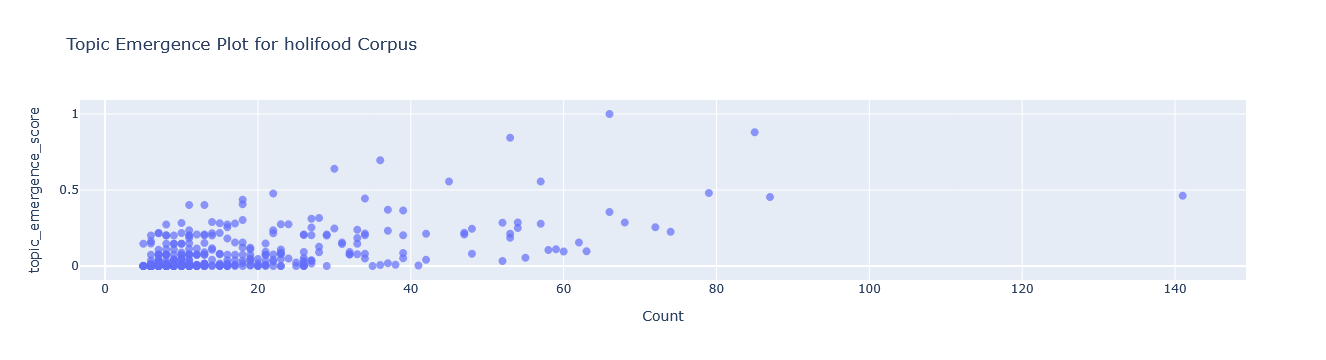

In [13]:
import plotly.graph_objects as go

fig = go.Figure()

# --- Plot all topics directly ---
fig.add_trace(
    go.Scatter(
        x=df_plot_magnitude["Count"],
        y=df_plot_magnitude["topic_emergence_score"],
        mode="markers",
        marker=dict(size=8, opacity=0.7),
        text=df_plot_magnitude["Name"],
        hovertext=df_plot_magnitude["Representation"].astype(str),
        name="All topics",
    )
)

# Axis + layout
fig.update_xaxes(title_text="Count")
fig.update_yaxes(title_text="topic_emergence_score")

fig.update_layout(
    title=f"Topic Emergence Plot for {name} Corpus"
)

fig.show()


[topic_emergence] Candidates after filters: Count in [5, 15], topic_emergence_score >= 0.2 -> 22 topics
[topic_emergence] Showing top 10 weak signals (target TOP_K_WEAK=10).


,Name,Count,score,weak_signal_score,Representation
0,213_citrus_juice_marinated_sensory,11,0.401407,0.722222,"[citrus, juice, marinated, sensory, marinade, marinating, meat, marination, beo, rhubarb]"
1,181_sers_imprinted_qcm_spr,13,0.401350,0.610969,"[sers, imprinted, qcm, spr, ecl, cap, cofaiecl, aptasensor, signal, detection]"
2,291_hets_alsub2subosub3sub_cuonps_nanosilver,8,0.273842,0.571281,"[hets, alsub2subosub3sub, cuonps, nanosilver, extracellular, nanosilverinduced, nets, formation, nanocu, release]"
3,382_haploid_dh_colchicine_hmf,6,0.200589,0.500009,"[haploid, dh, colchicine, hmf, doubling, landrace, capture, hff, haploids, ptx]"
4,347_dandelion_broth_uvbinduced_fermentation,7,0.217578,0.486752,"[dandelion, broth, uvbinduced, fermentation, skin, skincare, masks, ingredients, hacat, irritation]"
5,245_grain_dp51291_95275_dp915635,10,0.283340,0.483817,"[grain, dp51291, 95275, dp915635, diets, nontransgenic, containing, rats, pathology, fed]"
6,260_bps_mbp_extraction_canned,9,0.200822,0.333922,"[bps, mbp, extraction, canned, dese, hre, dess, uae, ethanol, solvents]"
7,164_lncrnas_de_flhs_poly,14,0.289955,0.278066,"[lncrnas, de, flhs, poly, fatty, mrnas, f1, h3k27ac, hens, f0]"
8,159_rhizosphere_2a5_2a7_transgenic,15,0.281705,0.201969,"[rhizosphere, 2a5, 2a7, transgenic, hemoglobin, stages, diversity, bt, mcry1ab, z58]"
9,197_za_solid_bac_144,12,0.207751,0.184508,"[za, solid, bac, 144, agents, black5, sn, diphenyl, ether, lactofen]"


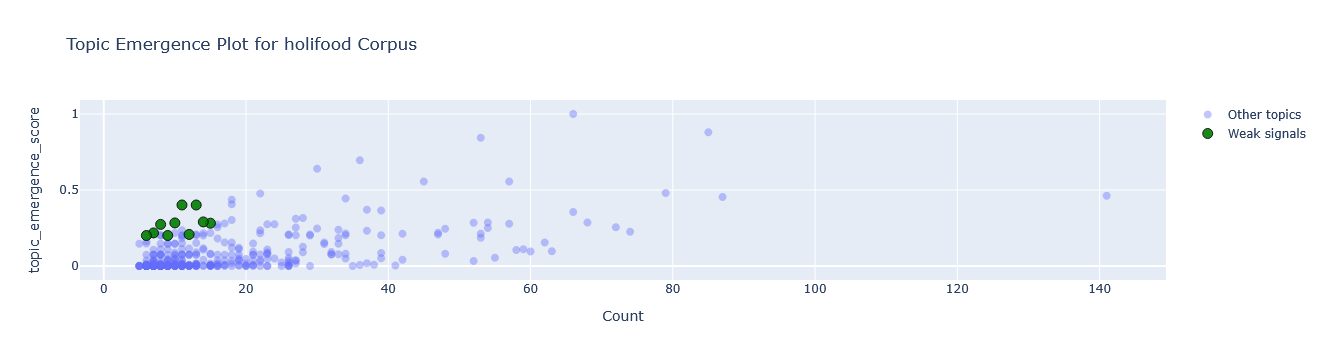

In [14]:
# --- Weak-signal ranking parameters ---
TOP_K_WEAK = 10                  # maximum number of weak signals to present
WEAK_MIN_COUNT = 5              # minimum topic Count to consider
WEAK_MIN_UPPER_COUNT = 15        # absolute upper bound for Count
SCORE_MIN_THRESHOLD = 0.2       # minimum recency_magnitude_score to be considered


# ============================================
# 11. TOP-K WEAK SIGNALS
# ============================================

def rank_weak_signals(df_plot, score_col, label):
    df_rank = df_plot.copy()

    # Ensure valid numeric values
    df_rank = df_rank.dropna(subset=[score_col, "Count"]).copy()
    df_rank = df_rank.rename(columns={score_col: "score"})

    lower = WEAK_MIN_COUNT
    upper = WEAK_MIN_UPPER_COUNT

    # -------------------------------------------------
    # 1) Hard filter: Count bounds + score threshold
    # -------------------------------------------------
    candidates = df_rank[
        (df_rank["Count"] >= lower) &
        (df_rank["Count"] <= upper) &
        (df_rank["score"] >= SCORE_MIN_THRESHOLD)
    ].copy()

    print(
        f"[{label}] Candidates after filters: "
        f"Count in [{lower}, {upper}], {score_col} >= {SCORE_MIN_THRESHOLD} -> {len(candidates)} topics"
    )

    if candidates.empty:
        print(f"[{label}] No weak-signal candidates after Count + score filters.")
        return pd.DataFrame()

    # -------------------------------------------------
    # 2) Compute weak_signal_score within candidates
    # -------------------------------------------------
    c_min, c_max = candidates["Count"].min(), candidates["Count"].max()
    if c_max > c_min:
        count_norm = 1.0 - (candidates["Count"] - c_min) / (c_max - c_min)
    else:
        count_norm = pd.Series(1.0, index=candidates.index)

    s = candidates["score"]
    s_min, s_max = s.min(), s.max()
    if s_max > s_min:
        score_norm = (s - s_min) / (s_max - s_min)
    else:
        score_norm = pd.Series(1.0, index=candidates.index)

    BETA = 0.5  # weight between score and (inverted) Count
    candidates["weak_signal_score"] = (
        BETA * score_norm + (1.0 - BETA) * count_norm
    )

    # -------------------------------------------------
    # 3) Round-robin selection by Count (even filling)
    # -------------------------------------------------
    def round_robin_by_count(pool, k):
        if pool.empty or k <= 0:
            return []

        # For each Count, keep indices sorted by weak_signal_score desc
        groups = {}
        for c, sub in pool.groupby("Count"):
            sub_sorted = sub.sort_values("weak_signal_score", ascending=False)
            groups[c] = list(sub_sorted.index)

        selected = []
        pointers = {c: 0 for c in groups}

        # Classic round-robin: cycle over Counts, pick next best from each
        while len(selected) < k:
            any_picked = False
            for c in sorted(groups):  # sorted by Count for determinism
                idx_list = groups[c]
                pos = pointers[c]

                if pos < len(idx_list):
                    selected.append(idx_list[pos])
                    pointers[c] = pos + 1
                    any_picked = True

                    if len(selected) >= k:
                        break

            if not any_picked:
                # No group has remaining candidates
                break

        return selected

    selected_idx = round_robin_by_count(candidates, TOP_K_WEAK)

    if not selected_idx:
        print(f"[{label}] Round-robin could not select any topics.")
        return pd.DataFrame()

    ws_top = candidates.loc[selected_idx].copy()
    ws_top = ws_top.sort_values("weak_signal_score", ascending=False)

    cols = ["Name", "Count", "score", "weak_signal_score", "Representation"]
    ws_top = ws_top[cols].reset_index(drop=True)

    print(
        f"[{label}] Showing top {len(ws_top)} weak signals "
        f"(target TOP_K_WEAK={TOP_K_WEAK})."
    )
    return ws_top

# Only compute the Recency+magnitude weak signals
ws_magnitude_top = rank_weak_signals(
    df_plot_magnitude,
    "topic_emergence_score",
    label="topic_emergence"
)

if not ws_magnitude_top.empty:
    with pd.option_context("display.max_colwidth", None):
        display(ws_magnitude_top)
else:
    print("No weak signals to display for Recency+magnitude scoring.")
    
import plotly.graph_objects as go

# --- Weak-signal mask from round-robin ranking (green) ---
weak_names = set(ws_magnitude_top["Name"])
mask_weak = df_plot_magnitude["Name"].isin(weak_names)

# Base: everything except weak signals
df_base = df_plot_magnitude[~mask_weak]
df_weak = df_plot_magnitude[mask_weak]

fig = go.Figure()

# --- Base layer: all non-weak-signal topics ---
fig.add_trace(
    go.Scatter(
        x=df_base["Count"],
        y=df_base["topic_emergence_score"],
        mode="markers",
        marker=dict(size=8, opacity=0.4),
        text=df_base["Name"],
        hovertext=df_base["Representation"].astype(str),
        name="Other topics",
    )
)

# --- Weak signals (green) ---
fig.add_trace(
    go.Scatter(
        x=df_weak["Count"],
        y=df_weak["topic_emergence_score"],
        mode="markers",
        marker=dict(
            size=10,
            color="green",
            line=dict(width=1, color="black"),
            opacity=0.9,
        ),
        text=df_weak["Name"],
        hovertext=df_weak["Representation"].astype(str),
        name="Weak signals",
    )
)

# Axis + layout
fig.update_xaxes(title_text="Count")
fig.update_yaxes(title_text="topic_emergence_score")

fig.update_layout(
    title=f"Topic Emergence Plot for {name} Corpus"
)

fig.show()


In [15]:
ws_magnitude_top.to_csv(f"/home/jupyter/WSM/data/{name}_weak_signals.csv", index=False)